In [1]:
import pickle
import numpy as np

In [2]:
with open('train_qa.txt', 'rb') as f:
  train_data = pickle.load(f)

In [3]:
with open('test_qa.txt', 'rb') as f:
  test_data = pickle.load(f)

In [4]:
type(train_data)

list

In [5]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [6]:
print(' '.join(train_data[0][0]))

Mary moved to the bathroom . Sandra journeyed to the bedroom .


In [7]:
all_data = test_data + train_data

In [8]:
print(len(all_data), len(test_data), len(train_data))

11000 1000 10000


In [9]:
vocab = set()

for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))
  # vocab = vocab.union(set(answer))

st = set(("yes", "no"))
vocab = vocab.union(st)

In [10]:
print(len(vocab))

37


In [11]:
vocab_len = len(vocab) + 1

In [12]:
all_story_lens = [len(data[0]) for data in all_data]

In [13]:
max_story_len = max(all_story_lens)

In [14]:
max_question_len = max([len(data[1]) for data in all_data])

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [17]:
tokenizer.word_index

{'apple': 1,
 'bathroom': 2,
 'daniel': 3,
 'milk': 4,
 'took': 5,
 '?': 6,
 'picked': 7,
 'kitchen': 8,
 'grabbed': 9,
 'yes': 10,
 'put': 11,
 'got': 12,
 'football': 13,
 'down': 14,
 'dropped': 15,
 'discarded': 16,
 'up': 17,
 'garden': 18,
 'left': 19,
 'mary': 20,
 'there': 21,
 'went': 22,
 '.': 23,
 'hallway': 24,
 'to': 25,
 'in': 26,
 'john': 27,
 'travelled': 28,
 'sandra': 29,
 'office': 30,
 'the': 31,
 'back': 32,
 'journeyed': 33,
 'is': 34,
 'no': 35,
 'bedroom': 36,
 'moved': 37}

In [18]:
train_story_text = []
train_question_text = []
train_answer = []

In [19]:
for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answer.append(answer)

In [20]:
print(train_story_text[:2])

[['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.'], ['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.']]


In [21]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [22]:
print(len(train_story_seq), len(train_story_text))

10000 10000


In [23]:
train_story_seq[0]

[20, 37, 25, 31, 2, 23, 29, 33, 25, 31, 36, 23]

In [24]:
def vectorize_stories(data,word_index,max_story_length,max_question_length):
  # Stories
  X = []
  # Questions
  Xq = []
  # Correct Ans
  Y = []

  for story,query,ans in data:
    x = [word_index[word.lower()] for word in story]
    X.append(x)

    q = [word_index[word.lower()] for word in query]
    Xq.append(q)

    # y = [word_index[word.lower()] for word in ans]
    y = np.zeros(len(word_index)+1)
    y[word_index[ans]] = 1
    Y.append(y)

  return (pad_sequences(X,maxlen=max_story_length),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))


In [25]:
inputs_train, queries_train, ans_train = vectorize_stories(train_data,
                                                           tokenizer.word_index,
                                                           max_story_len,
                                                           max_question_len)

In [26]:
inputs_test, queries_test, ans_test = vectorize_stories(test_data,
                                                        tokenizer.word_index,
                                                        max_story_len,
                                                        max_question_len)

In [27]:
inputs_test

array([[ 0,  0,  0, ..., 31, 36, 23],
       [ 0,  0,  0, ..., 31, 18, 23],
       [ 0,  0,  0, ..., 31, 18, 23],
       ...,
       [ 0,  0,  0, ..., 31,  1, 23],
       [ 0,  0,  0, ..., 31, 18, 23],
       [ 0,  0,  0, ...,  1, 21, 23]], dtype=int32)

In [28]:
sum(ans_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 503.,   0.,   0.])

In [29]:
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, add, dot, concatenate, LSTM, Permute
from keras.layers import Embedding

In [30]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [31]:
vocab_size = len(vocab)+1

In [32]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [33]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [34]:
# Question Encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [35]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [36]:
matched = dot([input_encoded_m,
             question_encoded],
            axes=(2,2))

matched = Activation('softmax')(matched)

In [37]:
response = add([matched, input_encoded_c])
response = Permute((2,1))(response)

In [38]:
answer = concatenate([response, question_encoded])

In [39]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [40]:
answer = LSTM(32)(answer)

In [41]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size, activation = "softmax")(answer)

In [42]:
model_bot = Model([input_sequence,
               question],
              answer)

In [43]:
model_bot.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [44]:
model_bot.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 6, 64)                2432      ['input_2[0][0]']             
                                                                                              

In [45]:
model_history = model_bot.fit([inputs_train,
                              queries_train],
                              ans_train,
                              batch_size = 32,
                              epochs = 200,
                              validation_data = ([inputs_test, queries_test], ans_test))

Epoch 1/200
313/313 [==============================] - 9s 10ms/step - loss: 0.8992 - accuracy: 0.4956 - val_loss: 0.6948 - val_accuracy: 0.5030
Epoch 2/200
313/313 [==============================] - 2s 7ms/step - loss: 0.7055 - accuracy: 0.5008 - val_loss: 0.6954 - val_accuracy: 0.5030
Epoch 3/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6986 - accuracy: 0.4928 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 4/200
313/313 [==============================] - 3s 8ms/step - loss: 0.6960 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/200
313/313 [==============================] - 2s 6ms/step - loss: 0.6958 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 6/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6957 - accuracy: 0.4954 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 7/200
313/313 [==============================] - 3s 8ms/step - loss: 0.6956 - accuracy: 0.4939 - val_loss: 0.6933 - val_accuracy: 0.497

In [48]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

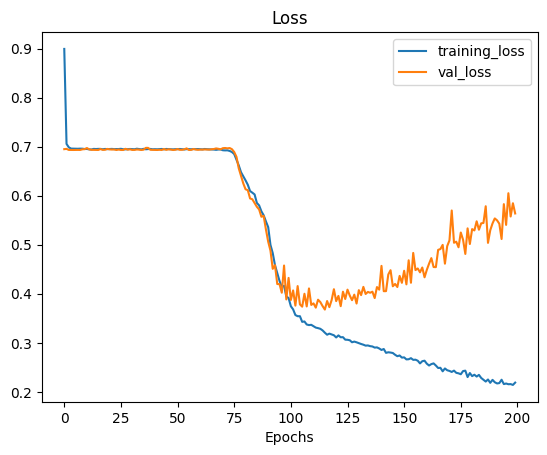

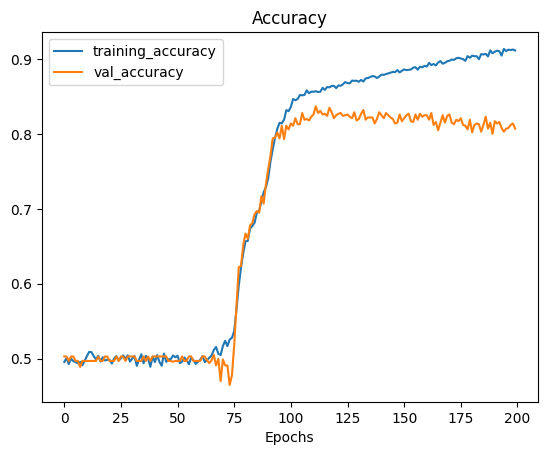

In [49]:
plot_loss_curves(model_history)

In [50]:
pred_results = model_bot.predict(([inputs_test,queries_test]))

32/32 [==============================] - 1s 4ms/step


In [53]:
test_data[0][2]

'no'

In [54]:
val_max = np.argmax(pred_results[0])

In [55]:
for key, val in tokenizer.word_index.items():
  if val==val_max:
    k = key

In [56]:
print(k)

no


In [57]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

In [58]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [59]:
my_question = "Is the football in the garden ?"

In [60]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [61]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [62]:
print(mydata)

[(['John', 'left', 'the', 'kitchen', '.', 'Sandra', 'dropped', 'the', 'football', 'in', 'the', 'garden', '.'], ['Is', 'the', 'football', 'in', 'the', 'garden', '?'], 'yes')]


In [63]:
my_story, my_ques, my_ans = vectorize_stories(mydata,
                                              tokenizer.word_index,
                                              max_story_len,
                                              max_question_len)

In [64]:
my_ans

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [65]:
pred_results = model_bot.predict(([my_story,my_ques]))

1/1 [==============================] - 0s 59ms/step


In [66]:
val_max = np.argmax(pred_results[0])

In [67]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [68]:
print(k)

yes


In [69]:
pred_results[0][val_max]

0.9913161